## Recurrent Neural Network

- Solve problems with sequence of information
    - Timeseries
    - Sentences
    - Audio
    - Car trajectories
    - Music
- Imagine a sequence [1,2,3,4,5,6], could we predict a similar sequence shifted one time step into the future - e.g. [2,3,4,5,6,7]
- Recurrent neuron sends output back to itself - at time t, neuron receives inputs from t and its own outputs from t-1 (2 sets of inputs). This can work at the neuron layer level too, where all the neurons in the layer receive the output from previous time step as input.
- Neuron cells that are a function of inputs from previous time steps are also known as memory cells
- RNN are also flexible in their inputs and outputs, for both sequences and single vector values
    - Sequence-to-sequence: input a sequence and get a sequence as output shifted by some time delta
    - Sequence-to-vector: input a sequence and expect a single vector result in future time step
    - Vector-to-sequence: input a single vector and expect a sequence output for multiple subsequent time steps
    
**Vanishing and Exploding Gradients**
- Backpropagation goes backwards from the output to the input layer, propagating the error gradient. For deeper networks, issues can arise from backpropagation, vanishing and exploding gradients
- As you go back to the "lower" layers - closer to the inputs - gradients often get smaller, eventually causing weights to never change at lower levels
- This is a product of the gradient being derived via the chain rule and with large number of layers, the derivative multiplications in the chain rule grow, always multiplying by smaller and smaller numbers. As N (number of layers) grow the number of terms in the chain rule grows. This is particularly bad for activation functions such as sigmoid or tanh
    - A solution is to use a different activation function - like ReLU
    - Another solution is to perform batch normalization, where your model will normalize each batch using the batch mean and standard deviation
    - Apart from batch normalization, researchers have also used "gradient clipping", where gradients are cut off before reaching a predetermined limit (e.g. cut off gradients to be between -1 and 1)
        - These solution can, however, slow down training, which we can overcome by shortening the time steps used for prediction, but this makes the model worse at predicting longer trends
    - The opposite can also occur, gradients exploding on the way back, causing issues.

- Another issue RNN face is that after a while the network will begin to "forget" the first inputs, as information is lost at each step going through the RNN
- We need some sort of "long-term memory" for our networks

**LSTM and GRU**

- **LSTM (Long Short-Term Memory)** cells were created to help address these RNN issues
    - They contain three parts: input (x_t), previous output (h_t-1) and previous cell state (c_t-1)
    - There decision gates within the cell to decide what information to keep and what to drop, as well as what will form the next state and output of the cell
- **GRU (Gated Recurrent Unit)**
    - They are variation in "architecture" of the LSTM cell

#### Manual RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Constants
num_inputs = 2
num_neurons = 3

In [3]:
# Placeholders - just for manual example; will not do this for real RNN
x0 = tf.placeholder(tf.float32, shape=[None, num_inputs])
x1 = tf.placeholder(tf.float32, shape=[None, num_inputs])

In [4]:
# Variables
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))
Wy = tf.Variable(tf.random_normal(shape=[num_neurons, num_neurons]))
b = tf.Variable(tf.zeros([1,num_neurons]))

In [5]:
# Graphs
y0 = tf.tanh(tf.matmul(x0, Wx) + b)
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx) + b)

In [6]:
init = tf.global_variables_initializer()

In [7]:
# Create data
# t0
x0_batch = np.array([[0,1], [2,3], [4,5]])

# t1
x1_batch = np.array([[100,101], [102,103], [104,105]])

In [8]:
with tf.Session() as session:
    session.run(init)
    
    y0_output_vals, y1_output_vals = session.run([y0,y1], feed_dict={x0:x0_batch, x1:x1_batch})

In [9]:
y0_output_vals

array([[-0.11950362, -0.5244624 , -0.95450324],
       [-0.7958292 ,  0.3442111 , -0.999991  ],
       [-0.96766245,  0.8617744 , -1.        ]], dtype=float32)

In [10]:
y1_output_vals

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]], dtype=float32)

#### RNN with Tensorflow

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
tf.__version__

'1.15.5'

In [12]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # Create btach time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # Create Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

In [13]:
ts_data = TimeSeriesData(250,0,10)

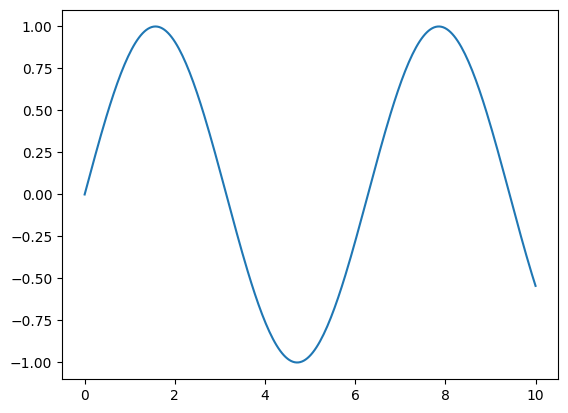

In [14]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [15]:
num_time_steps = 30
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

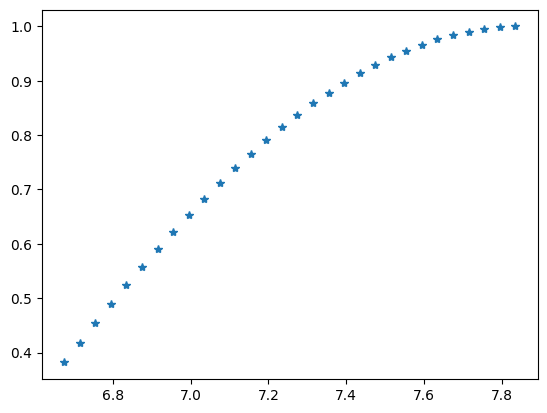

In [16]:
plt.plot(ts.flatten()[1:], y2.flatten(), "*")

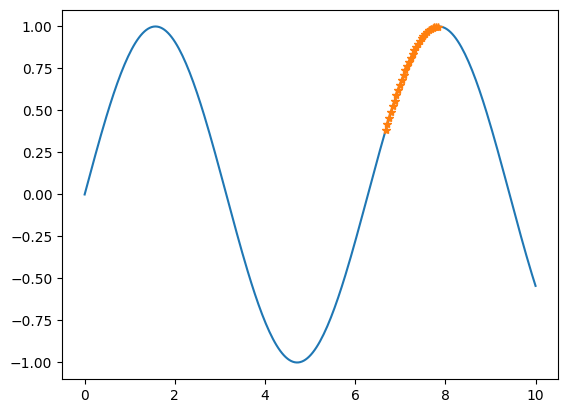

In [17]:
plt.plot(ts_data.x_data, ts_data.y_true, label="Sin(t)")
plt.plot(ts.flatten()[1:], y2.flatten(), "*", label="Single training instance")

##### Creating a model

In [18]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 5000
batch_size = 1

In [19]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [20]:
# RNN Cell Layer
# BasicCell
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs
# )

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


In [21]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [24]:
init = tf.global_variables_initializer()

In [25]:
saver = tf.train.Saver()

In [26]:
with tf.Session() as session:
    session.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        session.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE: ", mse)
    
    saver.save(session, "./models/rnn_ts_model")

0 	MSE:  0.30712542
100 	MSE:  0.14615434
200 	MSE:  0.10690151
300 	MSE:  0.31057823
400 	MSE:  0.07873573
500 	MSE:  0.01028929
600 	MSE:  0.018034846
700 	MSE:  0.0552794
800 	MSE:  0.00999121
900 	MSE:  0.04946165
1000 	MSE:  0.014595692
1100 	MSE:  0.00871088
1200 	MSE:  0.03698438
1300 	MSE:  0.02683128
1400 	MSE:  0.03890019
1500 	MSE:  0.015698595
1600 	MSE:  0.0026914852
1700 	MSE:  0.051360093
1800 	MSE:  0.03053241
1900 	MSE:  0.017653788
2000 	MSE:  0.036271513
2100 	MSE:  0.020521352
2200 	MSE:  0.02524027
2300 	MSE:  0.033625167
2400 	MSE:  0.04563273
2500 	MSE:  0.019935722
2600 	MSE:  0.012368629
2700 	MSE:  0.0067623
2800 	MSE:  0.003256552
2900 	MSE:  0.017370928
3000 	MSE:  0.0053539337
3100 	MSE:  0.02446667
3200 	MSE:  0.0032632905
3300 	MSE:  0.000415094
3400 	MSE:  0.019918568
3500 	MSE:  0.0052195787
3600 	MSE:  0.007582098
3700 	MSE:  0.0014063981
3800 	MSE:  0.011076856
3900 	MSE:  0.0034671405
4000 	MSE:  0.0077551855
4100 	MSE:  0.0002569549
4200 	MSE:  0.00

In [27]:
training_inst = ts_data.x_data[:31]

with tf.Session() as session:
    saver.restore(session, "./models/rnn_ts_model")
    
    X_new = np.sin(np.array(training_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = session.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./models/rnn_ts_model


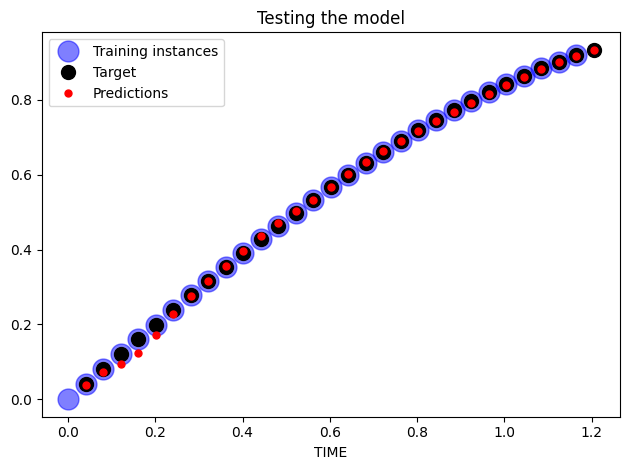

In [28]:
plt.title("Testing the model")

# Training instance
plt.plot(training_inst[:-1], np.sin(training_inst[:-1]), "bo", markersize=15, alpha=0.5, label="Training instances")

# Target to predict
plt.plot(training_inst[1:], np.sin(training_inst[1:]), "ko", markersize=10, label="Target")

# Models prediction
plt.plot(training_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="Predictions")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()


#### Generate new sequence

In [29]:
with tf.Session() as session:
    saver.restore(session, "./models/rnn_ts_model")
    
    # SEED
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = session.run(outputs, feed_dict={X: X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])


INFO:tensorflow:Restoring parameters from ./models/rnn_ts_model


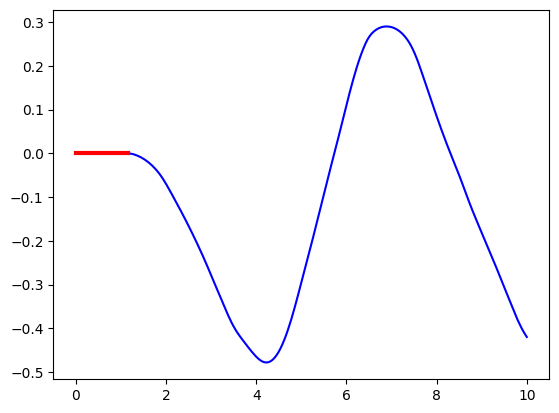

In [30]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)


In [31]:
with tf.Session() as session:
    saver.restore(session, "./models/rnn_ts_model")
    
    # SEED
    training_instance = list(ts_data.y_true[:30])
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = session.run(outputs, feed_dict={X: X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./models/rnn_ts_model


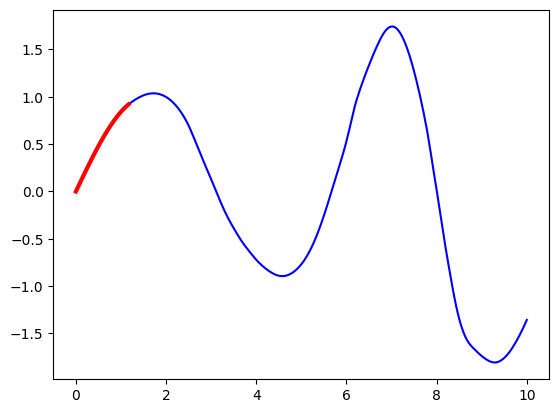

In [32]:
plt.plot(ts_data.x_data, training_instance, "b-")
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], "r", linewidth=3)